In [21]:
import os

# Ruta al dataset
dataset_path = './dataset_fake_real_kaggle_ml'

# Obtener la lista de archivos
filenames = os.listdir(dataset_path)

# Filtrar solo archivos de imagen
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [f for f in filenames if f.lower().endswith(image_extensions)]

# Contar cuántas son fake y cuántas reales
num_fake = sum(1 for f in image_files if f.startswith('fake'))
num_real = sum(1 for f in image_files if f.startswith('real'))

print(f"Total de imágenes: {len(image_files)}")
print(f"Fake: {num_fake}")
print(f"Real: {num_real}")


Total de imágenes: 8605
Fake: 4151
Real: 4454


In [22]:
import os

carpeta_fake_training = 'C:/Users/Naum Jahaziel/OneDrive/ITESO/maestria/AnalisisDatos/TodasLasImagenes/Fake/'
carpeta_real_training = 'C:/Users/Naum Jahaziel/OneDrive/ITESO/maestria/AnalisisDatos/TodasLasImagenes/Real/'

# Extensiones válidas
extensiones = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Contar imagenes en Fake
imagenes_fake = [f for f in os.listdir(carpeta_fake_training) if f.lower().endswith(extensiones)]
num_fake = len(imagenes_fake)

# Contar imagenes en Real
imagenes_real = [f for f in os.listdir(carpeta_real_training) if f.lower().endswith(extensiones)]
num_real = len(imagenes_real)

print(f"Imágenes Fake: {num_fake}")
print(f"Imágenes Real: {num_real}")
print(f"Total de imágenes: {num_fake + num_real}")


Imágenes Fake: 80981
Imágenes Real: 80827
Total de imágenes: 161808


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================
# FUNCIÓN DE EXTRACCIÓN DE FEATURES
# ================================
def extract_features(image):
    gray = cv2.resize(image, (128, 128))
    gray = cv2.equalizeHist(gray)
    gray = cv2.medianBlur(gray, 3)
    gray = cv2.bilateralFilter(gray, d=5, sigmaColor=50, sigmaSpace=50)
    
    
    #histogram of oriented gradients
    #hog extrae bordes, contornos, forma general, deteccion de objetos y reconocimiento facial 
    hog_features = hog(gray, orientations=12, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       transform_sqrt=True, feature_vector=True)
    
    P, R = 8, 1
    #local binary pattern
    #textura, patrones locales en la imagen
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    bins = np.arange(0, P + 3)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, P + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    features = np.hstack([hog_features, lbp_hist])
    features = features / (np.linalg.norm(features) + 1e-6)
    return features

# ================================
# DATA AUGMENTATION
# ================================
def augment_image(image):
    angle = np.random.choice([0, 90, 180, 270])
    M = cv2.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), angle, 1)
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    
    if np.random.rand() > 0.5:
        rotated = cv2.flip(rotated, 1) #voltea izquierda-derecha
    if np.random.rand() > 0.7:
        rotated = cv2.flip(rotated, 0) #voltea arriba-abajo
    
    if np.random.rand() > 0.7:
        #agregar ruido gaussiano
        noise = np.random.normal(0, 10, rotated.shape).astype(np.uint8)
        rotated = cv2.add(rotated, noise)
    
    #rotamos y escalamos para variar tamaño
    scale = np.random.uniform(0.9, 1.1)
    rotated = cv2.resize(rotated, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    
    return rotated

# ================================
# LECTURA DEL DATASET
# ================================
filenames = os.listdir('./dataset_fake_real_kaggle_ml')
categories = ['fake' if f.split('_')[0]=='fake' else 'real' for f in filenames]
dataset = pd.DataFrame({'filename': filenames, 'category': categories})

# Balanceo de clases
fake_sample = dataset[dataset['category']=='fake'].sample(n=4000, random_state=42)
real_sample = dataset[dataset['category']=='real'].sample(n=4000, random_state=42)
dataset_sample = pd.concat([fake_sample, real_sample]).reset_index(drop=True)

# ================================
# DIVIDIR EN TRAIN Y VALIDATION ANTES DE AUMENTAR
# ================================
train_df, val_df = train_test_split(
    dataset_sample,
    test_size=0.2,
    stratify=dataset_sample['category'],
    random_state=42
)

# ================================
# CREAR FEATURES PARA UN DATAFRAME
# ================================
def create_features(df, augment=False):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        file_path = os.path.join('./dataset_fake_real', row['filename'])
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Imagen original
        X.append(extract_features(img))
        y.append(1 if row['category']=='fake' else 0)
        
        # Imagen aumentada (si se desea)
        if augment:
            aug_img = augment_image(img)
            X.append(extract_features(aug_img))
            y.append(1 if row['category']=='fake' else 0)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int8)

# ================================
# CREAR TRAIN Y VALIDATION SETS
# ================================
X_train, y_train = create_features(train_df, augment=True)
X_val, y_val = create_features(val_df, augment=False)  # No augmentar validation

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


100%|██████████| 1600/1600 [00:55<00:00, 28.73it/s]


Train set: (12800, 10810) (12800,)
Validation set: (1600, 10810) (1600,)


In [24]:
train_filenames = set(train_df['filename'])
val_filenames = set(val_df['filename'])
intersect = train_filenames & val_filenames
print("Imágenes en ambos sets:", intersect)  # Debe ser un set vacío


Imágenes en ambos sets: set()


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ================================
# ESCALADO + PCA (solo con TRAIN)
# ================================
print("\nEscalando y aplicando PCA...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit solo con TRAIN
X_val_scaled = scaler.transform(X_val)          # transform con los mismos parámetros

pca = PCA(n_components=500, svd_solver='randomized', random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)  # fit solo con TRAIN
X_val_pca = pca.transform(X_val_scaled)          # transform con los mismos parámetros

print(f"Dimensionalidad reducida: {X_train_pca.shape[1]} componentes retenidos")

# ================================
# ENTRENAMIENTO DE MODELOS
# ================================
# --- Random Forest ---
print("\nEntrenando Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=2, random_state=42
)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_val_pca)
y_prob_rf = rf.predict_proba(X_val_pca)[:,1]

# --- KNN ---
print("\nEntrenando KNN...")
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_val_pca)
y_prob_knn = knn.predict_proba(X_val_pca)[:,1]

# --- SVM con GridSearchCV ---
print("\nEntrenando SVM (GridSearchCV)...")
svm_params = {
    'C': [0.5, 1, 3],
    'gamma': [0.001, 0.01, 'scale']
}
svm = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    svm_params,
    cv=3,
    n_jobs=-1,
    verbose=2
)
svm.fit(X_train_pca, y_train)
best_svm = svm.best_estimator_
y_pred_svm = best_svm.predict(X_val_pca)
y_prob_svm = best_svm.predict_proba(X_val_pca)[:,1]

print(f"\nMejor SVM encontrado: {best_svm}")




Escalando y aplicando PCA...
Dimensionalidad reducida: 500 componentes retenidos

Entrenando Random Forest...

Entrenando KNN...

Entrenando SVM (GridSearchCV)...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Mejor SVM encontrado: SVC(C=3, probability=True, random_state=42)



=== Random Forest ===
Accuracy:  0.7225
AUC:       0.8037
Precision: 0.6956
Recall:    0.7913
F1-score:  0.7404

Reporte completo:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       800
           1       0.70      0.79      0.74       800

    accuracy                           0.72      1600
   macro avg       0.73      0.72      0.72      1600
weighted avg       0.73      0.72      0.72      1600



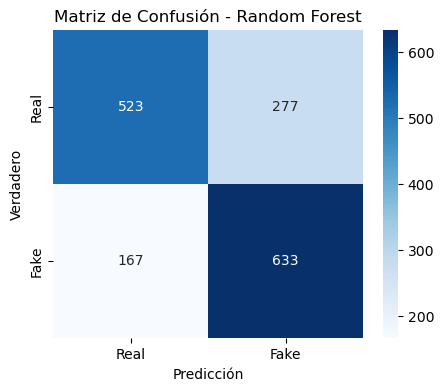


=== KNN ===
Accuracy:  0.9213
AUC:       0.9871
Precision: 0.9171
Recall:    0.9263
F1-score:  0.9216

Reporte completo:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       800
           1       0.92      0.93      0.92       800

    accuracy                           0.92      1600
   macro avg       0.92      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600



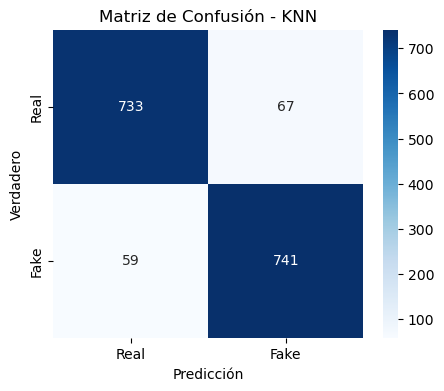


=== SVM ===
Accuracy:  0.9087
AUC:       0.9713
Precision: 0.9431
Recall:    0.8700
F1-score:  0.9051

Reporte completo:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       800
           1       0.94      0.87      0.91       800

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



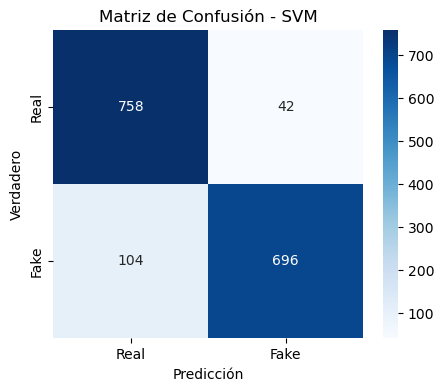


Validación cruzada SVM (5 folds): 0.8313 ± 0.0187


In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# ================================
# EVALUACIÓN
# ================================
modelos = {
    "Random Forest": rf,
    "KNN": knn,
    "SVM": best_svm
}

for nombre, modelo in modelos.items():
    print(f"\n=== {nombre} ===")
    
    # Usar X_val_pca que ya tiene escalado y PCA
    y_pred = modelo.predict(X_val_pca)
    y_prob = modelo.predict_proba(X_val_pca)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("\nReporte completo:")
    print(classification_report(y_val, y_pred))
    
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real','Fake'],
                yticklabels=['Real','Fake'])
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()


# ================================
# VALIDACIÓN CRUZADA DEL MEJOR MODELO (SVM)
# ================================
# Para CV, debemos usar X_train_pca + y_train o todo el dataset escalado y reducido
X_total_pca = np.vstack([X_train_pca, X_val_pca])
y_total = np.hstack([y_train, y_val])

scores = cross_val_score(best_svm, X_total_pca, y_total, cv=5, scoring='accuracy')
print(f"\nValidación cruzada SVM (5 folds): {np.mean(scores):.4f} ± {np.std(scores):.4f}")
